In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, recall_score

In [2]:
df = pd.read_csv('data/heart_2020_cleaned_binary.csv')

In [3]:
df.head()

,Unnamed: 0,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,...,Asian,Black,Hispanic,Other,White,Excellent_Health,Fair_Health,Good_Health,Poor_Health,Very_Good_Health
0,0,0,16.60,1,0,0,3.0,30.0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,0,20.34,0,0,1,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,0,26.58,1,0,0,20.0,30.0,0,1,...,0,0,0,0,1,0,1,0,0,0
3,3,0,24.21,0,0,0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,4,0,23.71,0,0,0,28.0,0.0,1,0,...,0,0,0,0,1,0,0,0,0,1


([<matplotlib.patches.Wedge at 0x20b37cbb130>,
 [Text(6.735557395310444e-17, 1.1, 'Has Heart Disease'),
  Text(-2.0206672185931328e-16, -1.1, 'Does Not Have Heart Disease')])

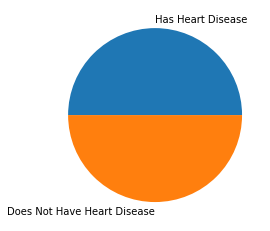

In [4]:
# Features that will be kept in models
keepThese = ['DiffWalking', 'PhysicalHealth', 'Diabetic_Yes', 'Stroke', 'Poor_Health', 'Fair_Health', '80 or older', 'Smoking', 'KidneyDisease']

# Separating data into Features and Targets
X = df[keepThese]
Y = df['HeartDisease']

# Balancing the data
balancer = RandomUnderSampler()
X, Y = balancer.fit_resample(X, Y)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#Scaling the data for better behavior with models
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Plotting Balanced Data
heart_labels = ['Has Heart Disease', 'Does Not Have Heart Disease']
plt.pie([len(df['HeartDisease'] == 1), len(df['HeartDisease'] == 0)], labels = heart_labels)

In [5]:
def get_performance(model_type, params, model_name):

    # Create Model
    model = model_type()
    
    # Cross Validation of Model
    model_cv = cross_validate(model, X_train, y_train, cv=3, scoring='f1')

    # Finding Best Parameters
    model_clf = GridSearchCV(model, param_grid=params, cv=3, scoring='f1', n_jobs=-1)
    model_clf.fit(X_train, y_train)
    model_best_params = model_clf.best_params_

    # Calculating Performance
    model_best = model_type(**model_best_params)
    model_best.fit(X_train, y_train)
    model_best_preds = model_best.predict(X_test)
    model_best_f1 = f1_score(y_test, model_best_preds)
    model_best_recall = recall_score(y_test, model_best_preds)

    # Displaying Output
    print(f"Cross Validation Accuracy: {model_cv['test_score'].mean()}")
    print(f"{model_name} GridSearchCV Best Parameters: {model_best_params}")
    print(f"{model_name} F1 Score: {model_best_f1}")
    print(f"{model_name} Recall: {model_best_recall}")

    return model_best

In [6]:
def get_feature_importance(model, model_name):
    importance_df = pd.DataFrame(zip(keepThese, model.feature_importances_), columns=["Features", f"{model_name} Importance Scores"])
    print(importance_df.sort_values(by=[f"{model_name} Importance Scores"], ascending=False))
    return importance_df

### Logistic Regression

In [7]:
# Parameters
params = {'solver': ['liblinear', 'saga'], 'C':[10**i for i in range(0,11)], 'penalty':['l1','l2']}

# Performance
log_reg = get_performance(LogisticRegression, params, 'Logistic Regression')

Cross Validation Accuracy: 0.6967311907384605
Logistic Regression GridSearchCV Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression F1 Score: 0.701652652942882
Logistic Regression Recall: 0.6580855692530819


### KNN

In [8]:
# Parameters
params = {'n_neighbors': [i for i in range(5, 11)], 'leaf_size': [i for i in range(30, 70, 10)]}

# Performance
knn = get_performance(KNeighborsClassifier, params, 'KNN')

Cross Validation Accuracy: 0.6691734250788736
KNN GridSearchCV Best Parameters: {'leaf_size': 60, 'n_neighbors': 9}
KNN F1 Score: 0.681782334384858
KNN Recall: 0.6269035532994924


### Decision Tree

In [9]:
# Parameters
params = {'criterion' : ["entropy"], 'min_samples_split': [i for i in range(30, 70, 10)], 'min_samples_leaf': [i for i in range(2,6,1)], 'max_depth': [i for i in range(12,17,1)]}

# Performance
dec_tree = get_performance(tree.DecisionTreeClassifier, params, 'Decision Tree')

# Feature Importance
dec_tree_importance = get_feature_importance(dec_tree, 'Decision Tree')

Cross Validation Accuracy: 0.6976178654228399
Decision Tree GridSearchCV Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 50}
Decision Tree F1 Score: 0.7105895398262798
Decision Tree Recall: 0.6970630891950689
         Features  Decision Tree Importance Scores
0     DiffWalking                         0.301289
2    Diabetic_Yes                         0.170607
6     80 or older                         0.127342
3          Stroke                         0.116269
7         Smoking                         0.082831
5     Fair_Health                         0.064002
1  PhysicalHealth                         0.052974
4     Poor_Health                         0.050014
8   KidneyDisease                         0.034673


### Ensemble Methods

In [10]:
ensemble = [AdaBoostClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
ensemble_names = ['AdaBoost', 'RandomForest', 'GradientBoosting']
for i in range(len(ensemble)):
    method = ensemble[i]

    method.fit(X_train, y_train)
    method_preds = method.predict(X_test)
    f1 = f1_score(y_test, method_preds)
    recall = recall_score(y_test, method_preds)
    method.fit(X_train, y_train)

    print(f"{ensemble_names[i]} F1 Score: {f1}")
    print(f"{ensemble_names[i]} Recall: {recall}")
    
    feature_importance = get_feature_importance(method, ensemble_names[i])

AdaBoost F1 Score: 0.693909626719057
AdaBoost Recall: 0.640319071791153
         Features  AdaBoost Importance Scores
1  PhysicalHealth                        0.58
0     DiffWalking                        0.10
4     Poor_Health                        0.08
6     80 or older                        0.06
2    Diabetic_Yes                        0.04
3          Stroke                        0.04
5     Fair_Health                        0.04
8   KidneyDisease                        0.04
7         Smoking                        0.02
RandomForest F1 Score: 0.7083757519666821
RandomForest Recall: 0.6937998549673676
         Features  RandomForest Importance Scores
0     DiffWalking                        0.188377
2    Diabetic_Yes                        0.178666
1  PhysicalHealth                        0.158123
6     80 or older                        0.122830
3          Stroke                        0.111371
5     Fair_Health                        0.079372
7         Smoking                   

In [11]:
# ensemble = [AdaBoostClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
# ensemble_names = ['AdaBoost', 'RandomForest', 'GradientBoosting']

params = {'criterion' : ["gini","entropy", "log_loss"], 'min_samples_split': [i for i in range(30, 70, 10)], 'min_samples_leaf': [i for i in range(2,6,1)], 'max_depth': [i for i in range(1,12,2)]}

dec_tree = get_performance(RandomForestClassifier, params, 'Random Forest')

# for i in range(len(ensemble)):
#     method = ensemble[i]

#     method.fit(X_train, y_train)
#     method_preds = method.predict(X_test)
#     f1 = f1_score(y_test, method_preds)
#     recall = recall_score(y_test, method_preds)
#     method.fit(X_train, y_train)

#     print(f"{ensemble_names[i]} F1 Score: {f1}")
#     print(f"{ensemble_names[i]} Recall: {recall}")

Cross Validation Accuracy: 0.7054866469608756
Random Forest GridSearchCV Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 50}
Random Forest F1 Score: 0.7176814774181752
Random Forest Recall: 0.7115663524292966


In [ ]:
rand_forest_fi = get_feature_importance(dec)